In [ ]:
#Importing all the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gradio as gr

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


c:\Users\thila\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#Generating the synthetic dataset 
np.random.seed(42)

n_samples = 1000
data = {
    "driver_id": [f"D{i:04}" for i in range(n_samples)],
    "avg_speed": np.random.normal(60, 10, n_samples),            # km/h
    "hard_brakes": np.random.poisson(2, n_samples),              # per trip
    "rapid_accels": np.random.poisson(2, n_samples),
    "phone_usage_mins": np.random.exponential(2, n_samples),     # per trip
    "night_driving_ratio": np.random.uniform(0, 1, n_samples),   # 0 to 1
    "accidents": np.random.binomial(1, 0.1, n_samples),          # binary label
}

df = pd.DataFrame(data)
df.head()


,driver_id,avg_speed,hard_brakes,rapid_accels,phone_usage_mins,night_driving_ratio,accidents
0,D0000,64.967142,1,3,0.302807,0.873556,0
1,D0001,58.617357,2,0,1.948631,0.329378,0
2,D0002,66.476885,1,2,0.465943,0.587795,0
3,D0003,75.230299,5,5,1.402641,0.847297,0
4,D0004,57.658466,1,1,1.574396,0.441274,0


In [ ]:
df.tail()  #This will give us the last 5 rows in the dataset

,driver_id,avg_speed,hard_brakes,rapid_accels,phone_usage_mins,night_driving_ratio,accidents,driving_score,risk_label,premium,feedback
995,D0995,57.188997,1,2,1.097906,0.541188,0,71.980427,Medium,9000.0,Reduce night-time driving
996,D0996,77.976865,2,2,1.015285,0.023716,0,77.495102,Low,9000.0,Excellent driving!
997,D0997,66.408429,4,2,0.053606,0.079789,0,68.297006,Medium,10000.0,Avoid harsh braking
998,D0998,54.288210,4,0,0.817613,0.417970,0,70.005383,Medium,9000.0,Avoid harsh braking
999,D0999,65.725828,1,3,7.461083,0.942913,0,46.219579,High,12000.0,"Limit phone usage while driving, Reduce night-..."


In [ ]:
#Creating a function to calculate the driving score depending upon driver behaviour
def calculate_driving_score(row):
    score = 100
    score -= row["hard_brakes"] * 5          #Reduces hand brakes score
    score -= row["rapid_accels"] * 5         #Reduces repid acceleration score
    score -= row["phone_usage_mins"] * 2   
    score -= row["night_driving_ratio"] * 20
    return max(score, 0)        #depending upon the driving beviour the score will get effected


df["driving_score"] = df.apply(calculate_driving_score, axis=1)
#Based upon the score assigning the labels like high,medium,low for it 
df["risk_label"] = pd.cut(df["driving_score"], bins=[0, 50, 75, 100], labels=["High", "Medium", "Low"])
df.head()


,driver_id,avg_speed,hard_brakes,rapid_accels,phone_usage_mins,night_driving_ratio,accidents,driving_score,risk_label,premium,feedback
0,D0000,64.967142,1,3,0.302807,0.873556,0,61.923275,Medium,10000.0,Reduce night-time driving
1,D0001,58.617357,2,0,1.948631,0.329378,0,79.515176,Low,9000.0,Excellent driving!
2,D0002,66.476885,1,2,0.465943,0.587795,0,72.312206,Medium,9000.0,Reduce night-time driving
3,D0003,75.230299,5,5,1.402641,0.847297,0,30.248782,High,12000.0,"Avoid harsh braking, Smoothen acceleration, Re..."
4,D0004,57.658466,1,1,1.574396,0.441274,0,78.025722,Low,9000.0,Excellent driving!


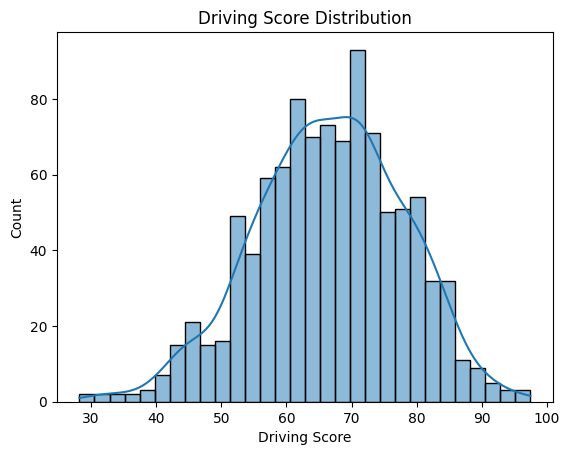

In [ ]:
sns.histplot(df["driving_score"], bins=30, kde=True)
plt.title("Driving Score Distribution")
plt.xlabel("Driving Score")
plt.ylabel("Count")
plt.show()

#By looking at the plot we can understand how the drivers are distributed
# based upon on the labels 


In [ ]:
#Training the data
features = ["avg_speed", "hard_brakes", "rapid_accels", "phone_usage_mins", "night_driving_ratio"]
X = df[features]
y = df["risk_label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#We have used the 80% of the data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        High       1.00      0.33      0.50        15
         Low       0.97      0.76      0.85        49
      Medium       0.86      0.99      0.92       136

    accuracy                           0.89       200
   macro avg       0.94      0.69      0.76       200
weighted avg       0.90      0.89      0.87       200



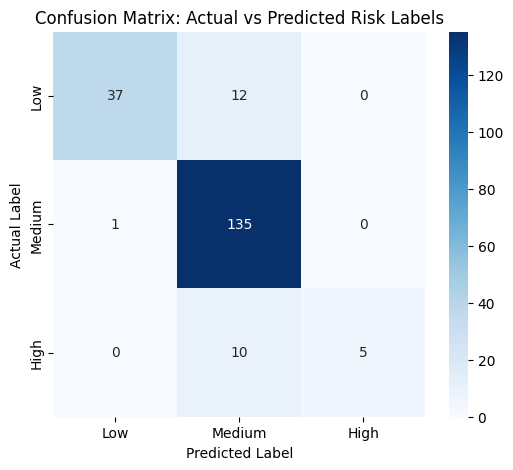

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["Low", "Medium", "High"])

# Plot it as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low", "Medium", "High"],
            yticklabels=["Low", "Medium", "High"])

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix: Actual vs Predicted Risk Labels")
plt.show()


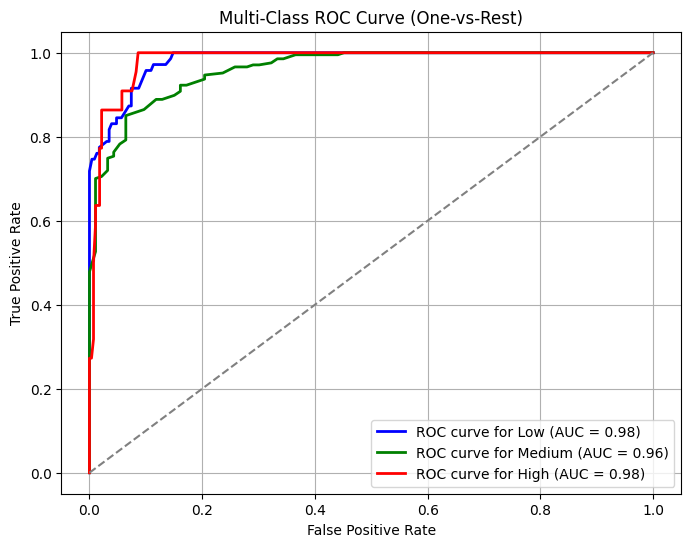

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# 1. Prepare features & labels
X = df[["avg_speed", "hard_brakes", "rapid_accels", "phone_usage_mins", "night_driving_ratio"]]
y = df["risk_label"]

# 2. Binarize the multi-class labels for OvR
classes = ["Low", "Medium", "High"]
y_bin = label_binarize(y, classes=classes)
n_classes = y_bin.shape[1]

# 3. Split and scale
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X, y_bin, test_size=0.3, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train One-vs-Rest model
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
model.fit(X_train_scaled, y_train_bin)

# 5. Predict probabilities
y_score = model.predict_proba(X_test_scaled)

# 6. Plot ROC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 7. Plot all curves
colors = ['blue', 'green', 'red']
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"ROC curve for {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
df.to_csv("telematics_insurance_data.csv", index=False)

In [42]:
# Add after import statements like:
import gradio as gr
import os
import csv
from datetime import datetime

# Then paste this:
class CustomFlagSaver(gr.FlaggingCallback):
    def setup(self, components, flagging_dir):
        self.flagging_dir = flagging_dir or "flagged"
        os.makedirs(self.flagging_dir, exist_ok=True)

    def flag(self, flag_data, flag_option=None, username=None):
        if flag_option == "Incorrect prediction":
            filename = "incorrect_predictions.csv"
        elif flag_option == "Unexpected premium":
            filename = "unexpected_premium.csv"
        else:
            filename = "predictions.csv"

        filepath = os.path.join(self.flagging_dir, filename)
        row = flag_data + [flag_option, datetime.now().strftime("%Y-%m-%d %H:%M:%S")]

        write_header = not os.path.exists(filepath)
        with open(filepath, mode="a", newline="") as f:
            writer = csv.writer(f)
            if write_header:
                writer.writerow(["Driver ID", "Speed", "Brakes", "Accels", "Phone", "Night Ratio", "Risk", "Premium", "Feedback", "Flag Reason", "Timestamp"])
            writer.writerow(row)


In [ ]:
import matplotlib.pyplot as plt
import io
from PIL import Image

def predict_risk_and_premium(driver_id, avg_speed, hard_brakes, rapid_accels, phone_usage, night_ratio):
    #  Validate Driver ID
    if not (driver_id.startswith("D") and driver_id[1:].isdigit() and 0 <= int(driver_id[1:]) <= 999):
        return "Incorrect Driver ID", "-", "-", None

    # Predict as usual
    features = pd.DataFrame([[avg_speed, hard_brakes, rapid_accels, phone_usage, night_ratio]],
        columns=["avg_speed", "hard_brakes", "rapid_accels", "phone_usage_mins", "night_driving_ratio"])

    scaled = scaler.transform(features)
    risk = clf.predict(scaled)[0]

    # Score and premium
    score = 100 - (hard_brakes * 5 + rapid_accels * 5 + phone_usage * 2 + night_ratio * 20)
    score = max(score, 0)

    if score >= 85:
        premium = 8000
    elif score >= 70:
        premium = 9000
    elif score >= 50:
        premium = 10000
    else:
        premium = 12000

    #  Feedback
    feedback = give_feedback(hard_brakes, rapid_accels, phone_usage, night_ratio)
    if avg_speed > 80:
        feedback += " Monitor the speed limit while driving."

    # Visualization: Feature Impact
    labels = ['Hard Brakes', 'Rapid Accels', 'Phone Usage', 'Night Driving']
    penalties = [hard_brakes * 5, rapid_accels * 5, phone_usage * 2, night_ratio * 20]

    plt.figure(figsize=(6, 4))
    plt.barh(labels, penalties, color='orangered')
    plt.xlabel("Penalty Points")
    plt.title("Driving Behavior Penalty Breakdown")
    plt.tight_layout()

    # Convert to image
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)

    return risk, f"₹{premium}", feedback, img


In [ ]:
iface = gr.Interface(
    fn=predict_risk_and_premium,
    inputs=[
        gr.Textbox(label="Driver ID"),
        gr.Slider(0, 150, value=60, label="Average Speed (km/h)"),
        gr.Slider(0, 10, value=2, step=1, label="Hard Brakes (count)"),
        gr.Slider(0, 10, value=2, step=1, label="Rapid Accelerations (count)"),
        gr.Slider(0, 20, value=2, label="Phone Usage (mins per trip)"),
        gr.Slider(0, 1, value=0.2, step=0.01, label="Night Driving Ratio"),
    ],
    outputs=[
        gr.Text(label="Driving Risk Level"),
        gr.Text(label="Adjusted Premium"),
        gr.Text(label="Driving Feedback"),
        gr.Image(label="Driving Behavior Visualization")  #  Chart output
    ],
    title="Telematics-Based Usage Insurance Estimator",
    description="Get your insurance premium, risk, feedback, and see a behavior breakdown.",
    allow_flagging="manual",
    flagging_options=["Incorrect prediction", "Unexpected premium", "Other"],
    flagging_callback=CustomFlagSaver()
)

iface.launch()




#Incorrect Prediction
#Use when the risk level prediction is wrong based on the inputs.

#Example:
#You input:

#Very low speed (40), no hard brakes, no phone usage

#But it still says "High Risk"

#This means: the model misclassified the risk.

#Click: Incorrect prediction

#Unexpected Premium
#Use when the premium seems unfair for the driving behavior.

#Example:
#You input:

#Safe behavior (score should be high)

#The model says risk is "Low"

#But premium is ₹12000 (which is very high)

#This means: prediction is fine, but pricing logic may be wrong.

#Click: Unexpected premium

#Other
#Use when something else feels off (UI glitch, feedback mismatch, etc.)

#Example:
#You enter wrong driver ID, but it still runs

#Feedback message is not relevant

#Model takes too long or crashes

#This is for any issue that’s not related to prediction or premium directly

#Click: Other



c:\Users\thila\anaconda3\envs\tf\lib\site-packages\gradio\interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7869
* To create a public link, set `share=True` in `launch()`.
